In [71]:
%load_ext autoreload
%reload_ext autoreload
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *

data_path = '../../AICity_data/train/S03/c010/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
means, stds = get_background_stats(data_path + 'vdo.avi', 1, 514) # 514 is the 25% of the frames

100%|█████████████████████████████████████████| 513/513 [00:08<00:00, 62.44it/s]


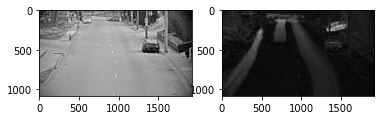

In [3]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(means, cmap='gray')
axs[1].imshow(stds, cmap='gray')

plt.show()

In [140]:
def closing(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, element)

def opening(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, element)

# def getBoxesFromMask(name, mask, kernel=5):
#     cleaned = cleanMask(mask, kernel)
#     cv2.imwrite(name, cleaned)
#     output = cv2.connectedComponentsWithStats(np.uint8(cleaned), 8, cv2.CV_32S)
#     (numLabels, labels, boxes, centroids) = output
#     detectedElems = []
#     for box in boxes[1:]: #First box is always the background
#         if box[4] > 500: #Try to do a better estimation of the minimunm size
#             # print(box)
#             b = VehicleDetection(0, -1, float(box[0]), float(box[1]), float(box[2]), float(box[3]), float(-1))
#             detectedElems.append(b)
#             # tl = (int(b.xtl), int(b.ytl))
#             # br = (int(b.xbr), int(b.ybr))
#             # color = (255,0,0)
#             # image = cv2.rectangle(image, tl, br, color, 2)
#     return detectedElems

# def getBoxesFromMask(mask):
#     output = cv2.connectedComponentsWithStats(np.uint8(mask), 8, cv2.CV_32S)
#     (numLabels, labels, boxes, centroids) = output
#     detectedElems = []
#     for box in boxes[1:]: #First box is always the background
#         if box[4] > 500: #Try to do a better estimation of the minimunm size
#             b = VehicleDetection(0, -1, float(box[0]), float(box[1]), float(box[2]), float(box[3]), float(-1))
#             detectedElems.append(b)

#     return detectedElems

def remove_background(means, stds, videoPath, ROIpath, alpha=4, sigma=2, kernelMorph=5):
    roi = cv2.imread(ROIpath, cv2.IMREAD_GRAYSCALE)
    
    vidcap = cv2.VideoCapture(videoPath)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    detections = {}
    for frame in tqdm(range(num_frames)):
        _, image = vidcap.read()
        if frame >= num_frames // 4:
            img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            img_mask = np.zeros(img_gray.shape, dtype = np.uint8)
            img_mask[abs(img_gray - means) >= alpha * (stds + sigma)] = 255

            cleaned = opening(img_mask, 5, 5) #initial removal of small noise
            cleaned = closing(cleaned, 2, 50) #vertical filling of areas [SWITCH TO HORIZONTAL?]
            cleaned = opening(cleaned, 40, 5) #removal of thin erroneous vertical lines
            cleaned = closing(cleaned, 100, 100) #filling of gaps
            cleaned = opening(cleaned, 20, 60) #removing shadows and similars [REVISE]

            roi_applied = cv2.bitwise_and(cleaned, roi)

            cv2.imwrite(f'./masks/mask_{frame}.png', roi_applied)

            detections[str(frame)] = getBoxesFromMask(cleaned)

    return detections

In [32]:
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')

In [141]:
singleGaussianDetections = remove_background(means, stds, data_path + 'vdo.avi', data_path + 'roi.jpg', 3.8, 2, 7)

100%|███████████████████████████████████████| 2141/2141 [01:31<00:00, 23.42it/s]


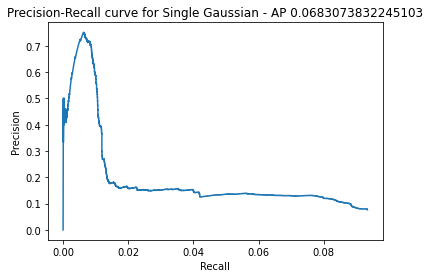

In [7]:
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for Single Gaussian - AP {ap}')

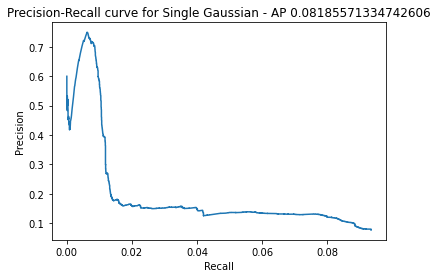

In [8]:
recs, precs, aps = ap_wo_conf(gt_detect,singleGaussianDetections)
plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Single Gaussian - AP {np.mean(aps)}')

100%|███████████████████████████████████████| 2141/2141 [01:44<00:00, 20.40it/s]


With Alpha 2.0 the AP is 0.022727272727272728


100%|███████████████████████████████████████| 2141/2141 [01:44<00:00, 20.56it/s]


With Alpha 3.857142857142857 the AP is 0.06868686868686869


100%|███████████████████████████████████████| 2141/2141 [01:42<00:00, 20.94it/s]


With Alpha 5.714285714285714 the AP is 0.08211143695014662


100%|███████████████████████████████████████| 2141/2141 [01:40<00:00, 21.36it/s]


With Alpha 7.571428571428571 the AP is 0.07185391028185788


100%|███████████████████████████████████████| 2141/2141 [01:39<00:00, 21.49it/s]


With Alpha 9.428571428571429 the AP is 0.0668327106683271


100%|███████████████████████████████████████| 2141/2141 [01:29<00:00, 23.86it/s]


With Alpha 11.285714285714286 the AP is 0.06681270536692224


100%|███████████████████████████████████████| 2141/2141 [01:27<00:00, 24.43it/s]


With Alpha 13.142857142857142 the AP is 0.05818181818181818


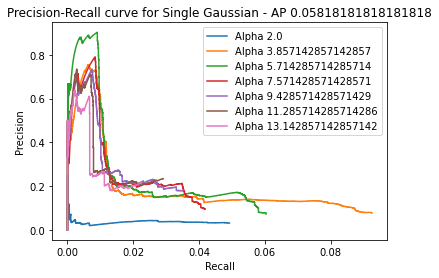

In [9]:
alphas = np.linspace(2.0, 15, num=7, endpoint=False)
precs, recs, lables = [], [], []
for alpha in alphas:
    singleGaussianDetections = remove_background(means,stds, data_path + 'vdo.avi', alpha, 2, 7) #kernel for closing 7
    rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
    print(f'With Alpha {alpha} the AP is {ap}')
    lables.append(f'Alpha {alpha}')
    precs.append(prec)
    recs.append(rec)

plot_multiple_prec_recall_curves(precs, recs, lables, f'Precision-Recall curve for Single Gaussian - AP {ap}')

In [10]:
alphas = np.linspace(2.0, 15, num=10)
precs, recs, lables = [], [], []
for alpha in alphas:
    singleGaussianDetections = remove_background(means,stds, data_path + 'vdo.avi', alpha, 2, 5) #kernel for closing 5
    rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
    print(f'With Alpha {alpha} the AP is {ap}')
    lables.append(f'Alpha {alpha}')
    precs.append(prec)
    recs.append(rec)

plot_multiple_prec_recall_curves(precs, recs, lables, f'Precision-Recall curve for Single Gaussian (kernel 5) - AP {ap}')

100%|███████████████████████████████████████| 2141/2141 [01:53<00:00, 18.83it/s]


With Alpha 2.0 the AP is 0.09090909090909091


 45%|██████████████████▏                     | 971/2141 [00:28<00:34, 33.52it/s]


KeyboardInterrupt: 

In [ ]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetectorAll', 514, 2100)